#Project 1: Modeling
by: Amoreena Ordonez and Zeynep Turk

In [179]:
#importing packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


url = "https://raw.githubusercontent.com/zsturk/Dat402_Proj1/refs/heads/main/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(url, sep = ",")

This dataset was sourced from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition). It includes 2111 observations about health indicators and obesity levels collected in 2019 from survey participants in Colombia, Peru, and Mexico. It contains a mix of categorical and numerical features for each subject along with a target variable that classifies the subject as either Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.  
Our goal for this project to is find which combination of possible factors for unhealthy weight can best predict its appearance in subjects. This knowledge can help inform key risk factors for for providers to focus on when concerned about a patient who comes in underweight or obese. To begin, let's look at the variables in our data:

* Gender
* Age
* Height [in meters]
* Weight [in kilograms]
* Family history of overweight
* FAVC: Frequently eat high calorie food [yes/no]
* FCVC: Eat vegetables [never, sometimes, always; encoded numerically]
* NCP: Number of main meals per day
* CAEC: Snacking between meals [no, sometimes, frequently, always]
* Smoking [yes/no]
* CH2O: Daily water consumption [less than 1 liter, between 1 and 2 liters, more than 2 liters]
* SCC: Calorie tracking [yes/no]
* FAF: Frequency of exercise [per week: 0, 1-2 days, 2-4 days, 4-5 days]
* TUE: Screentime (phone, TV, videogames, computer) [0-2 hours, 3-5 hours, > 5 hours]
* CALC: Frequency of alcohol consumption
* MTRANS: Usual method of transportation
* NObeyesdad: Weight classification

##Cleaning data

Let's start with a peek at our data, as well as checking if it has any missing values.

In [ ]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


There are no missing values.

Some of the columns are numeric while others not; this is something we need to adjust. The final column can stay as a categorical variable, however, because it represents the targets for classification. That being said, let's look at what those targets are.

In [ ]:
df["NObeyesdad"].value_counts()

,count
NObeyesdad,
Obesity_Type_I,351
Obesity_Type_III,324
Obesity_Type_II,297
Overweight_Level_I,290
Overweight_Level_II,290
Normal_Weight,287
Insufficient_Weight,272


For the purposes of this project, we will consolidate the tiers for overweight and obesity, giving a total of four targets for classification: underweight, normal, overweight, and obese.

In [180]:
df['NObeyesdad'] = df['NObeyesdad'].replace({"Overweight_Level_I" : "Overweight",
                                             "Overweight_Level_II" : "Overweight",
                                             "Obesity_Type_I" : "Obesity",
                                             "Obesity_Type_II" : "Obesity",
                                             "Obesity_Type_III" : "Obesity"
                                             })

We saw that many of the object columns are binary (yes/no), or ordinal (sometimes, frequently, etc). `MTRANS` (method of transportation) is a nominal measurement. For the first two types of variables, I will use label encoding to convert them to numbers; for `MTRANS` I will use one hot encoding with `pd.get_dummies()`, as the transportation categories don't have any inherent order:

In [ ]:
df["MTRANS"].value_counts()

,count
MTRANS,
Public_Transportation,1580
Automobile,457
Walking,56
Motorbike,11
Bike,7


In [181]:
#copy our df
numeric_df = df.copy()

encoder = OrdinalEncoder()

numeric_df = pd.get_dummies(numeric_df,
                            columns = ["Gender", "family_history_with_overweight","FAVC", "SMOKE", "SCC"],
                            drop_first = True,
                            dtype = int)

#ordinal label encoding
numeric_df["CAEC"] = encoder.fit_transform(numeric_df[["CAEC"]])
numeric_df["CALC"] = encoder.fit_transform(numeric_df[["CALC"]])

#nominal one hot encoding
numeric_df = pd.get_dummies(numeric_df,
                            columns = ["MTRANS"],
                            drop_first = True,
                            dtype = int)

Print out the cleaned data set just to make sure the appropriate columns are numeric:

In [ ]:
numeric_df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,2.0,0.0,1.0,3.0,Normal_Weight,0,1,0,0,0,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,2.0,3.0,3.0,0.0,2.0,Normal_Weight,0,1,0,1,1,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,Normal_Weight,1,1,0,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,2.0,0.0,1.0,Overweight,1,0,0,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,2.0,2.0,0.0,0.0,2.0,Overweight,1,0,0,0,0,0,0,1,0


##Exploratory Data Analysis

Since the combination of our height and weight variables would formulaically determine weight classification we will leave those out of our exploration and modeling.  Let's take a look at the distribution of our dependent variable we hope to predict in our sample and see if there are any strong correlations between it and our independent variables.

There seem to be many variables that intuitively feel like would be good predictors for weight classification levels, but age seems to stand out as not particularly relevant. To know if this is case we can look at the mean age across all weight levels to see if one varies greatly from another.

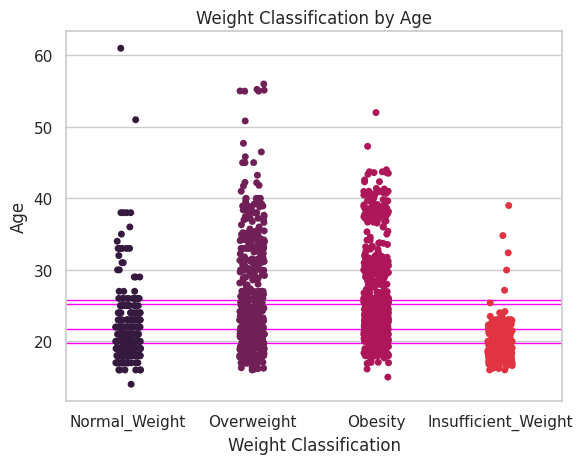

In [182]:
sns.set(style = "whitegrid", palette = "rocket")
sns.stripplot(x = 'NObeyesdad', y = 'Age', data = df, hue = "NObeyesdad")
plt.title("Weight Classification by Age")
plt.xlabel("Weight Classification")
means = df.groupby('NObeyesdad')['Age'].mean()
for Age in means.index:
  plt.axhline(means[Age], color = 'magenta', linestyle = '-', linewidth = 1)


The graph shows that there is not one singular weight level that has a large amount of observations in a drastically different age group than any other. Overweight and Obesity have more observations in the 30-40 year age range, but they have far more observations overall and the ages with the most observations of all four levels occur in the same group. The mean lines show only about a 5 year range in which they all fall which tells us that we can safely move forward with removing Age as a probable factor associated with weight level.

Text(0.5, 0, 'Weight classification')

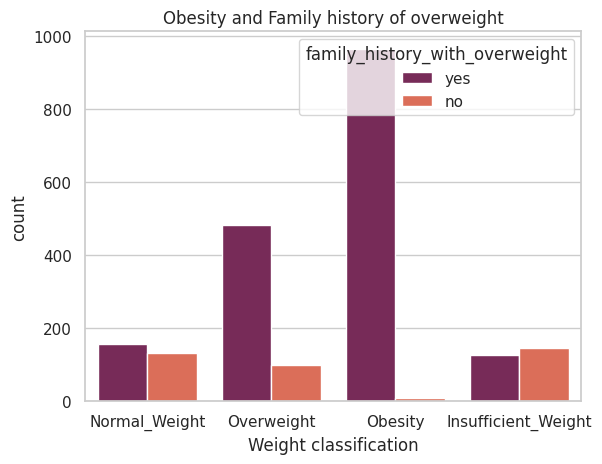

In [183]:
sns.countplot(data = df,
            x = "NObeyesdad",
            hue = "family_history_with_overweight",
            palette = "rocket"
           )
plt.title("Obesity and Family history of overweight")
plt.xlabel("Weight classification")

A sizeable majority of obesity and overweight observations are associated with a family history of overweight. This could be due to genetics, or other factors relating to where the family lives (including food access), or some other reason.

Text(0, 0.5, 'Weight [kg]')

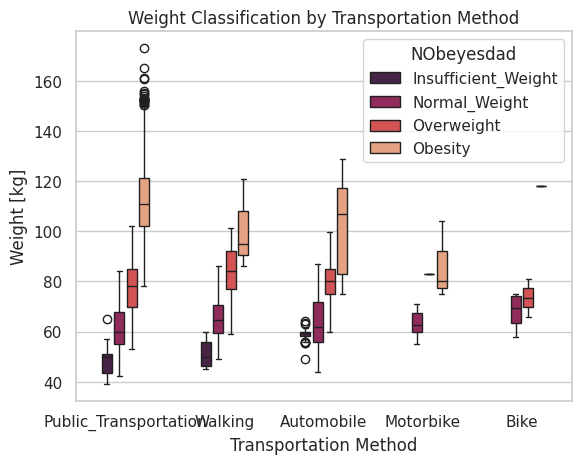

In [184]:
sns.boxplot(data = df,
            x = "MTRANS",
            y = "Weight",
            hue = "NObeyesdad",
            hue_order = ["Insufficient_Weight", "Normal_Weight", "Overweight", "Obesity"],
            palette = "rocket",
            width = .5,
            gap = .2,
            ).set_title("Weight Classification by Transportation Method")
plt.xlabel("Transportation Method")
plt.ylabel("Weight [kg]")


This graph suggests some interesting trends: those who take public transportation span *every* weight category, while those who bike are notably non-obese. Perhaps biking helps to lose weight, or, those who are already in better shape prefer to bike.

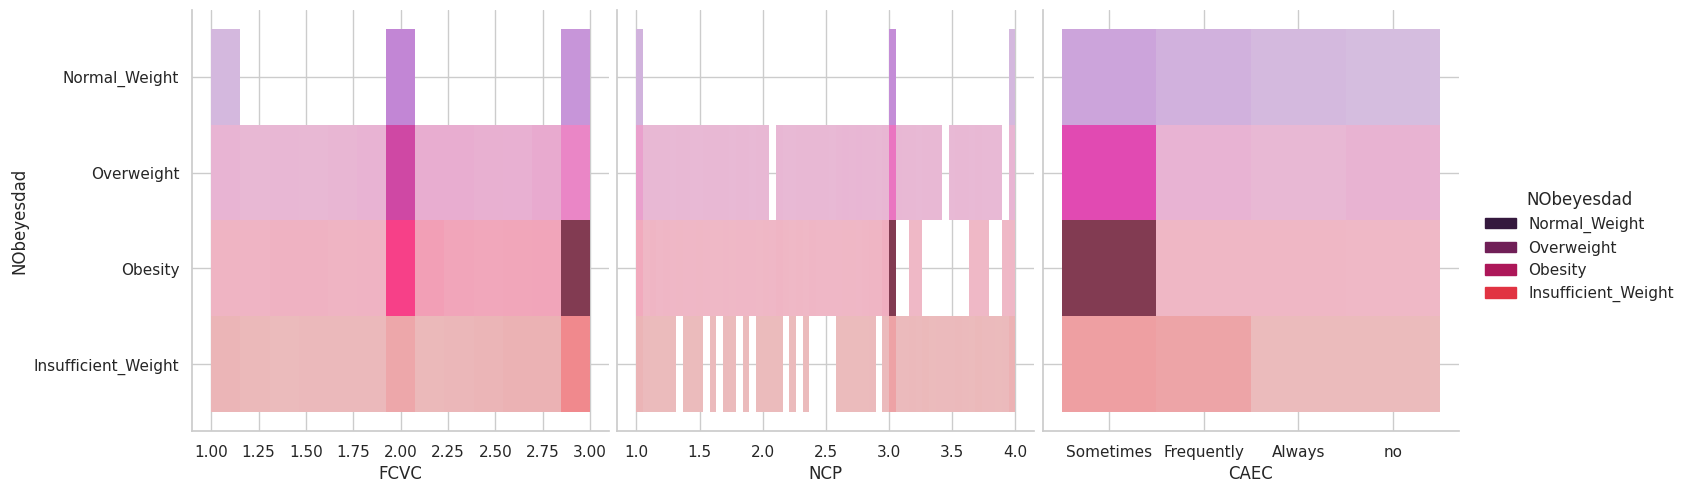

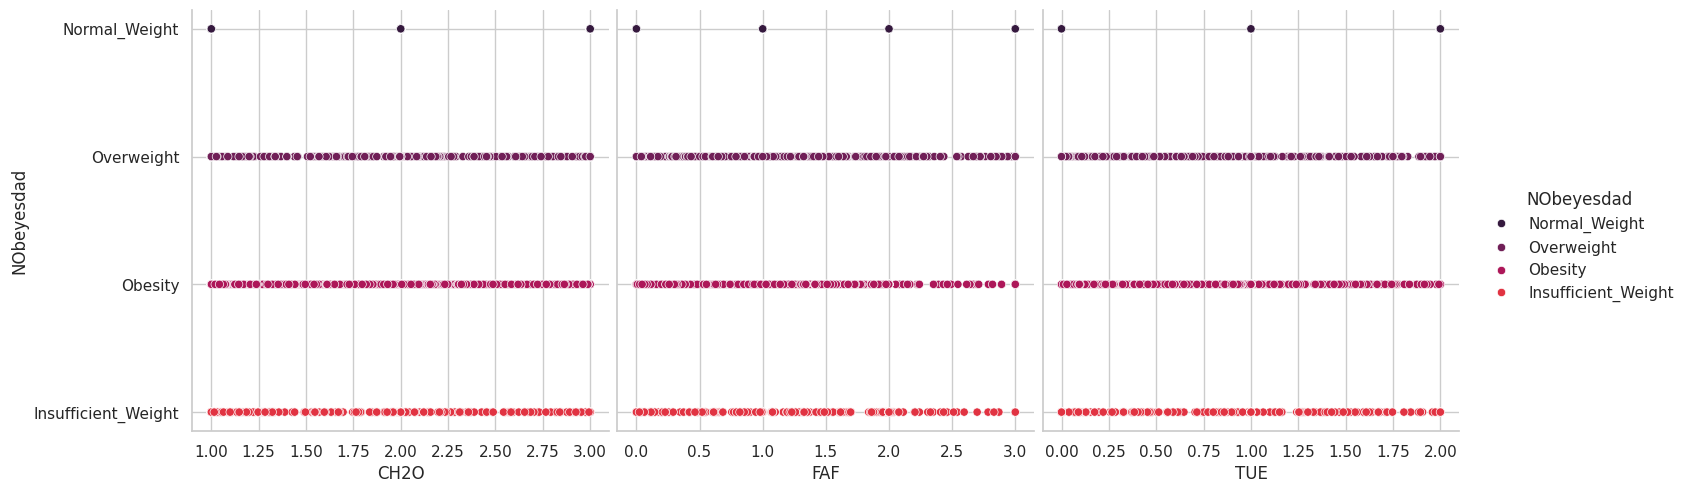

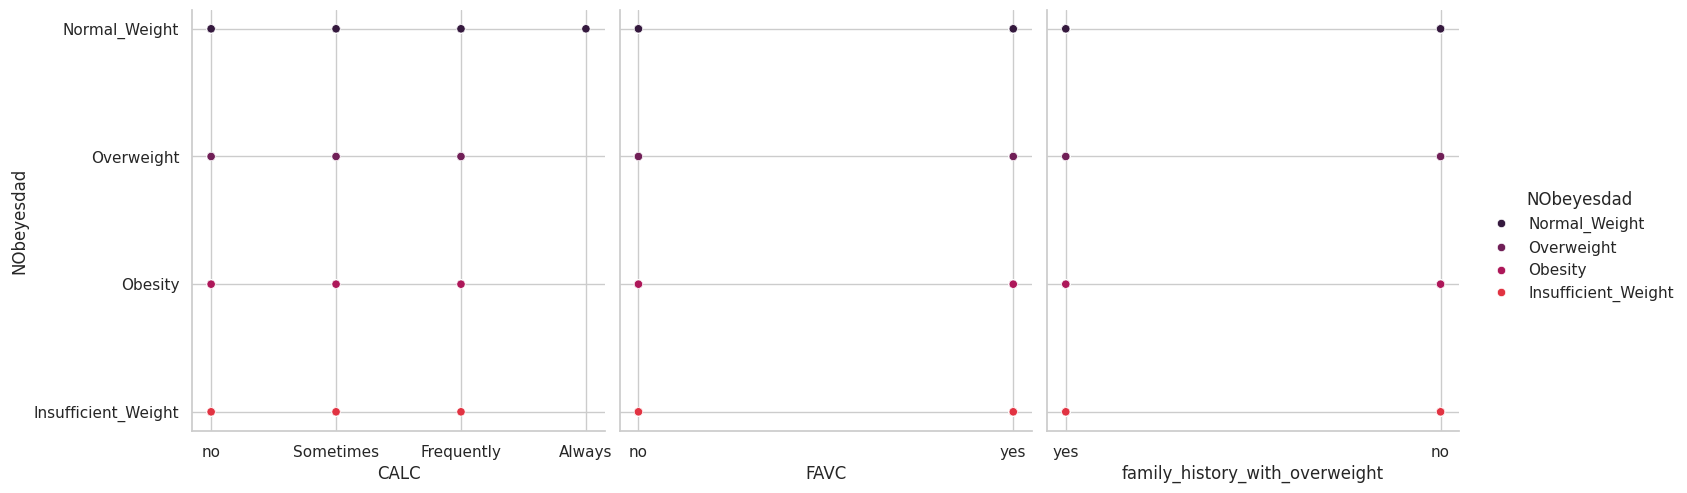

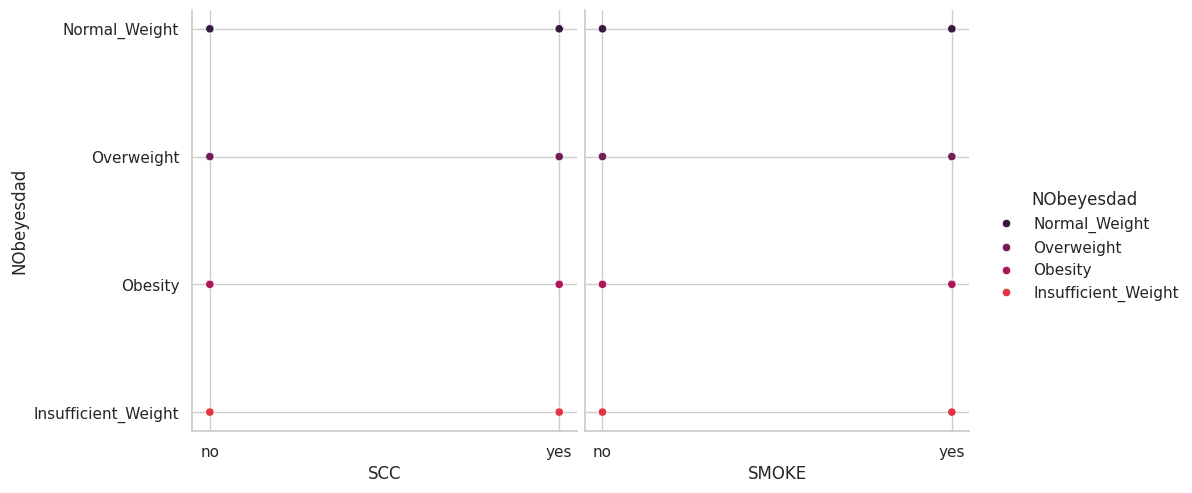

In [185]:

sns.pairplot(df, hue = "NObeyesdad", y_vars = ['NObeyesdad'], x_vars = ['FCVC', 'NCP', 'CAEC'], height = 5, aspect = 1, kind = 'hist')
sns.pairplot(df, hue = "NObeyesdad", y_vars = ['NObeyesdad'], x_vars = [ 'CH2O', 'FAF', 'TUE'], height = 5, aspect = 1)
sns.pairplot(df, hue = "NObeyesdad", y_vars = ['NObeyesdad'], x_vars = ['CALC', 'FAVC',
                                             'family_history_with_overweight'], height = 5, aspect = 1)
sns.pairplot(df, hue = "NObeyesdad", y_vars = ['NObeyesdad'], x_vars = ['SCC', 'SMOKE'], height = 5, aspect = 1)

##Splitting the dataset, scaling etc

Before we can create a method for prediction, we'll use the cleaned-up DataFrame numeric_df to split the data into a training set and a testing set for the model. For our purposes and data size we will create an 80/20 split respectively after shuffling the observations to ensure randomness. While we could do this step by step, there exists a function from sickit-learn that will consolidate our code and include partitioning a validation set to save us more lines later.

In [186]:
X = numeric_df[['FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'FAVC_yes',
                'family_history_with_overweight_yes', 'SCC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike',
                'MTRANS_Public_Transportation', 'MTRANS_Walking']]
y = numeric_df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4, test_size = .20, shuffle = True)


We can double check that the split was successful by comparing the distribution of the values in our target variable NObeyesdad in the train and test set. If all went well they should be close to the same.

In [ ]:
y_train.value_counts(normalize = True)

,proportion
NObeyesdad,
Obesity,0.458531
Overweight,0.275474
Normal_Weight,0.135664
Insufficient_Weight,0.130332


In [ ]:
y_test.value_counts(normalize = True)

,proportion
NObeyesdad,
Obesity,0.468085
Overweight,0.271868
Normal_Weight,0.137116
Insufficient_Weight,0.122931


So far, so good! Let's normalize our independent variables from our two new sets for the models that will depend on them.

In [187]:
scaler = StandardScaler()
X_trainstd = scaler.fit_transform(X_train)
X_teststd = scaler.fit_transform(X_test)

##Model 1: k - Nearest Neighbor Classification
Our first model is k - Nearest Neighbor Classification, typically used for categorical target variables such as our case. We can use another sklearn function KNeighborsClassifier() to create, fit, and test the model with a default parameter of k = 5.


In [188]:
knn = KNeighborsClassifier()
knn.fit(X_trainstd, y_train)
y_pred = knn.predict(X_teststd)

Now we can check the accuracy score of the predictions to see if we need to fine-tune k.

In [189]:
accuracy_score(y_test, y_pred)

0.7399527186761229

While that's not an awful accuracy score, we did only use the default value for the function so let's see if we can find a different value for k that may yield a higher accuracy score. To do this we will run a for loop iterating through values 5 to 100 and take the mean error rate for each predictions done with each one. I chose 100 because it seemed to be reasonably large enough that our optimal value would reside within it, but not unecessarily large enough that it would cost computational time for increasing bias.

In [190]:
error = []
kvec = range(5,100)
for i in kvec:
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_trainstd, y_train)
  y_pred = knn.predict(X_teststd)
  error.append(np.mean(1 - accuracy_score(y_pred, y_test)))


Minimum Error:  0.25531914893617025
k Value index:  1


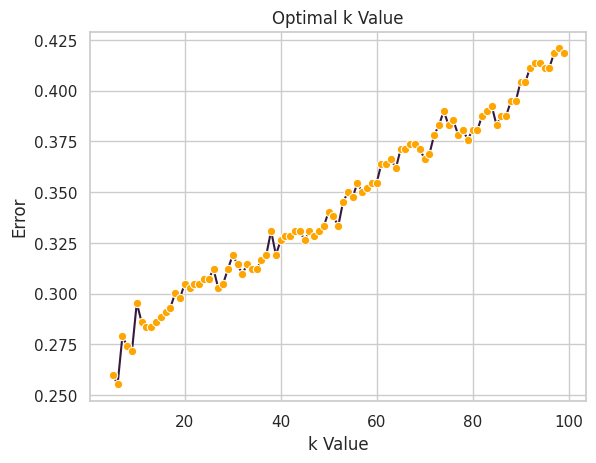

In [191]:
sns.lineplot(x = kvec, y = error, marker = 'o', markerfacecolor = 'orange')
plt.xlabel("k Value")
plt.ylabel("Error")
plt.title("Optimal k Value")

print('Minimum Error: ', min(error))
print('k Value index: ', error.index(min(error)))

From the plot above it's clear that once our k value hits 20 the error only grows and our minimum value of error is at 6. Let's run the same knn model with this new k value and see how much it will improve our accuracy score.

In [192]:
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_trainstd, y_train)
y_pred = knn.predict(X_teststd)
accuracy_score(y_test, y_pred)

0.7446808510638298

This the best accuracy score we will receive from the model based on the error plot and it is only marginally better than our original. Let's try using cross validation to ensure that this score is the best representation of how well our model works and that it isn't overestimating or underestimating its performance. Initially I was inclined to use Leave-One-Out validation, but since this is a large dataset we'll use Stratified k-Fold validation to split and retest the data in more manageable groups of 5.

In [193]:


skf = StratifiedKFold(n_splits = 5, shuffle = True)
skfAccuracy = []

for i, (train_index, test_index) in enumerate(skf.split(X,y)):
     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
     knn.fit(X_train, y_train)
     y_pred = knn.predict(X_test)
     skfAccuracy.append(accuracy_score(y_test, y_pred))

print('Average Accuracy of Each Fold:', np.mean(skfAccuracy))
print('Maximum Accuracy', max(skfAccuracy))
print('Minimum Accuracy', min(skfAccuracy))



Average Accuracy of Each Fold: 0.7342565516005064
Maximum Accuracy 0.7535545023696683
Minimum Accuracy 0.7186761229314421


Based on the results of our cross-validation it seems our k - Nearest Neighbors model with k = 6 is relatively accurate. Even though its accuracy score is at the max of our Stratified k - Fold, it is still technically within the range. And based on the average accuracy score of all 5 groups there isn't much room for further hyperparameter tuning that would drastically change its accuracy. We can safely assume that our k-NN model with k = 6 is the best we can tune our model and we can plot a heatmap confusion matrix of predicted values against true values to gain more insight.

Text(0.5, 1.0, 'Confusion Matrix for kNN model (k = 6)')

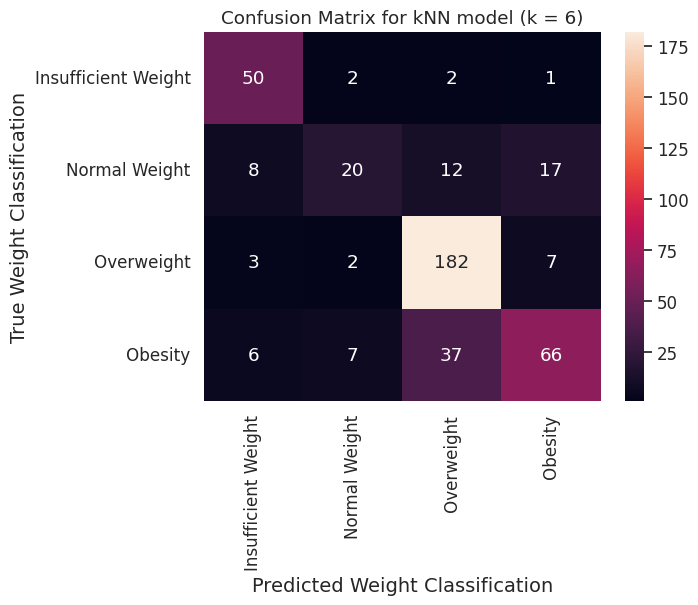

In [199]:
sns.set(font_scale = 1.1, palette = "rocket")
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd', xticklabels = ["Insufficient Weight", "Normal Weight", "Overweight", "Obesity"],
            yticklabels = ["Insufficient Weight", "Normal Weight", "Overweight", "Obesity"])
plt.xlabel("Predicted Weight Classification", fontsize = 14)
plt.ylabel("True Weight Classification", fontsize = 14)
plt.title("Confusion Matrix for kNN model (k = 6)")



The highest overlap in predictions and true values were in the overweight classification, not so closely followed by obesity and insufficient weight. This isn't ideal considering the aim of our model was to accurately predict patients who would be in the obesity or insufficient weight categories, but the good news is that in all four classifications the highest concentrations are accurate predictions.

##Model 2: Support Vector Machine

Using `GridSearchCV` to find best value of C parameter in SVM, C is for regularization, l2 penalty, etc. Testing in 10s because that's what scikit documentation suggested/showed

In [ ]:
#train/tune first
#specify parameter in question
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(SVC(),
                           param_grid,
                           scoring = "accuracy",
                           cv = 10, #5 is default
                           verbose = 0) #maybe need not be so verbose
grid_search.fit(X_trainstd, y_train)

#svm = SVC(kernel="rbf") #C parameter for regularization


GridSearchCV(cv=10, estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

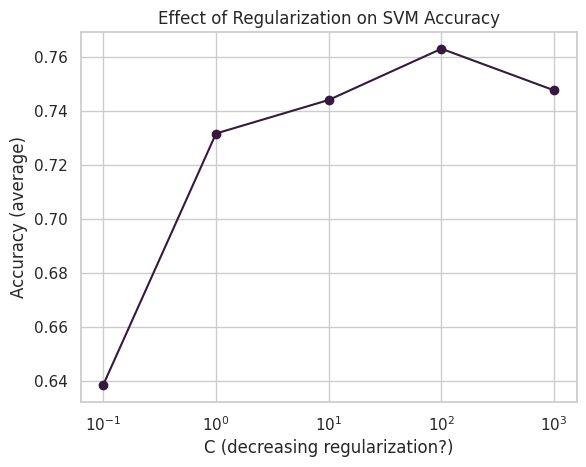

In [ ]:
c_values = param_grid['C']
accuracy_scores = grid_search.cv_results_['mean_test_score']

plt.plot(c_values, accuracy_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('C (decreasing regularization?)')
plt.ylabel('Accuracy (average)')
plt.title('Effect of Regularization on SVM Accuracy')
plt.grid(True)
plt.show()

A C value of 100 seems optimal, with an accuracy around 76% for the training set.

In [ ]:
#predict
svm = SVC(C = 100, random_state = 123)
svm.fit(X_trainstd, y_train)
svm_prediction = svm.predict(X_teststd)

In [ ]:
print(classification_report(y_test, svm_prediction))

                     precision    recall  f1-score   support

Insufficient_Weight       0.76      0.81      0.79        52
      Normal_Weight       0.60      0.59      0.59        58
            Obesity       0.82      0.90      0.86       198
         Overweight       0.74      0.61      0.67       115

           accuracy                           0.77       423
          macro avg       0.73      0.73      0.73       423
       weighted avg       0.76      0.77      0.76       423



Looking at the f1-score, which balances the precision and recall values, this model has an accuracy of 77% after optimizing the C parameter.

It is also possible to visualize the results using a confusion matrix.

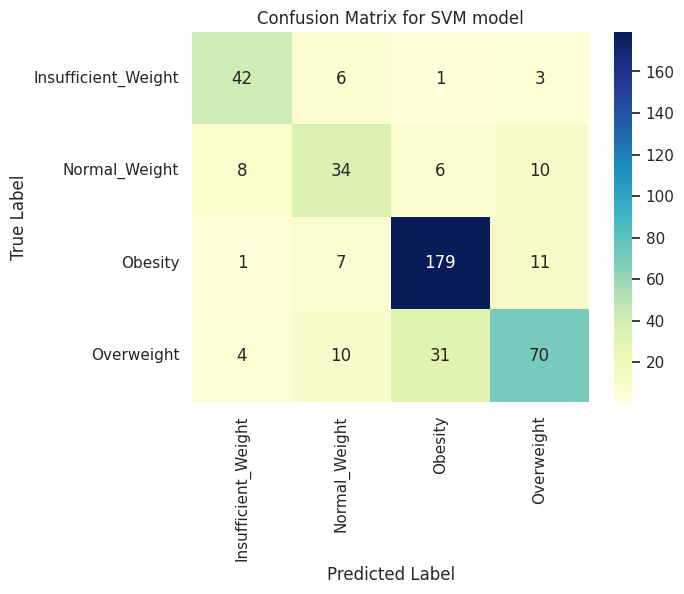

In [ ]:
#graph the performance
cm = confusion_matrix(y_test, svm_prediction)
sns.heatmap(data = cm,
            annot = True,
            fmt = "d",
            cmap = "YlGnBu",
            xticklabels = ["Insufficient_Weight", "Normal_Weight", "Obesity", "Overweight"],
            yticklabels = ["Insufficient_Weight", "Normal_Weight", "Obesity", "Overweight"]
            )
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVM model")
plt.show()

This model is comparatively worse at classifying normal weight cases, but better for obesity.

##Conclusion

